In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
# MNIST 데이터 셋
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())

batch_size = 16
# 데이터 로더
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


In [10]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [11]:
images, labels = next(iter(train_loader))
labels
torch.unique(labels)

tensor([0, 1, 3, 4, 5, 7, 8, 9])

In [4]:
images, labels = next(iter(train_loader))
print(images.size())  # -> [b, c, h, w] batch, channel, height, width
print(labels.size())

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [5]:
labels

tensor([6, 5, 0, 9, 0, 4, 9, 3, 3, 6, 2, 0, 8, 5, 4, 6])

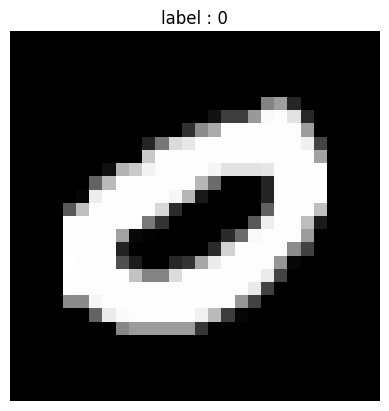

In [6]:
import matplotlib.pyplot as plt
ind = 2
img = images[ind].squeeze()
label = labels[ind]

plt.imshow(img, cmap='gray')
plt.title(f'label : {label.item()}')
plt.axis('off')
plt.show()

In [7]:
# 신경망 모델
class NeuralMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU())
        
        self.block2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU())
        
        self.output = nn.Linear(hidden_size, num_class)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        out = self.output(x)
        return out

In [18]:
# 하이퍼파라미터 설정
input_size = 28 * 28
hidden_size = 500
num_class = 10

num_epochs = 5
lr = 0.001

model = NeuralMLP(input_size=input_size, hidden_size=hidden_size, num_class=num_class).to(device)
# print(model)

# 손실함수, 옵티마이저
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# 모델 학습
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader, start=1):
        # 이미지 크기 조정
        # images = images.reshpae(-1, input_size).to(device)
        images = images.reshape(batch_size, -1).to(device)
        labels = labels.to(device)
        
        # 순전파 계산
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # 역전파, 옵티마이저
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print(f"Epoch [{epoch+1}/{num_epochs}, Step{i}/{total_step}, loss : {loss.item()}]")
    print(f"Epoch [{epoch+1}/{num_epochs}, loss : {loss.item()}]")
    
    # 모델 테스트
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(batch_size, -1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Test Acc : {100 * correct/total}")

Epoch [1/5, loss : 0.20000730454921722]
Test Acc : 96.24
Epoch [2/5, loss : 0.5640885829925537]
Test Acc : 97.13
Epoch [3/5, loss : 0.007229188922792673]
Test Acc : 97.89
Epoch [4/5, loss : 0.045832470059394836]
Test Acc : 97.57
Epoch [5/5, loss : 0.000619497848674655]
Test Acc : 97.89


In [19]:
# CNN 모델

class NeuralCNN(nn.Module):
    def __init__(self, input_ch, num_class):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(input_ch, 32, kernel_size=3, padding=1),
            nn.ReLU())
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU())
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU())
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU())
        self.pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        self.output = nn.Linear(256, num_class)
    
    def forward(self, x):   # c, h, w
        x = self.block1(x)  # 32, 28, 28
        x = self.block2(x)  # 64, 28, 28
        x = self.pool(x)    # 64, 14, 14
        
        x = self.block3(x)  # 128, 14, 14
        x = self.block4(x)  # 256, 14, 14 
        x = self.gap(x)     # 256, 1, 1
                            # x.squeeze() -> 256
        out = self.output(x.squeeze())  # -> 10
        return out

In [22]:
lr = 0.001
num_epochs = 5
model = NeuralCNN(input_ch=1, num_class=10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, loss {loss.item():.4f}")
    
    with torch.no_grad():
        correct = 0
        total = 0
        
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
            
        print(f"Test Acc : {100 * correct/total}")

Epoch 1/5, loss 0.1714
Test Acc : 96.61
Epoch 2/5, loss 0.1879
Test Acc : 97.47
Epoch 3/5, loss 0.5909
Test Acc : 98.65
Epoch 4/5, loss 0.0006
Test Acc : 98.95
Epoch 5/5, loss 0.0158
Test Acc : 98.7


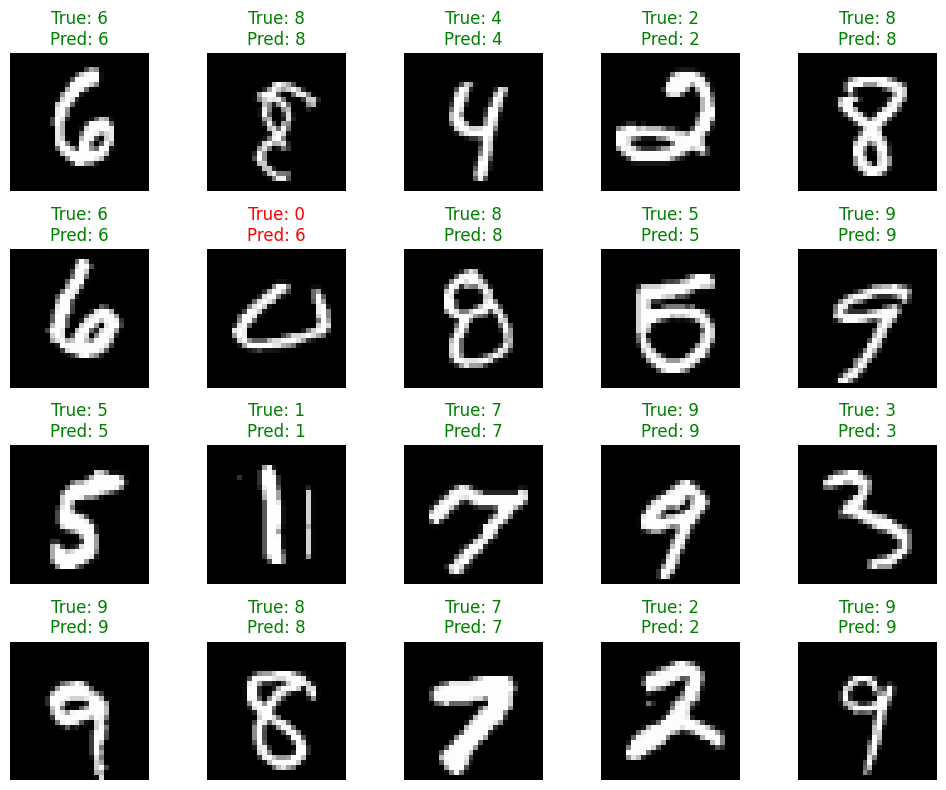

In [35]:
import matplotlib.pyplot as plt
import numpy as np

sample_indices = np.random.choice(len(test_dataset), 20, replace=False)
sample_images = [test_dataset[i][0] for i in sample_indices]
sample_labels = [test_dataset[i][1] for i in sample_indices]

#모델예측
model.eval()
predicted_labels=[]
with torch.no_grad():
    for image in sample_images:
        image = image.to(device)
        output = model(image).argmax()
        predicted_labels.append(output.item())

# 결과 시각화
fig, axes = plt.subplots(4,5, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(sample_images[i].squeeze().numpy(), cmap='gray')
    ax.set_title(f"True: {sample_labels[i]}\nPred: {predicted_labels[i]}",
                 color='green' if sample_labels[i]==predicted_labels[i] else 'red')
    ax.axis('off')
plt.tight_layout()
plt.show()